# Bonds: preditor de interações no proteoma humano com LLMs

<img src="assets/bonds.png" alt="Bonds logo, an emoji hugging a protein" width="100"/>

## Introdução

Proteínas são compostas por uma cadeia de moléculas orgânicas denominadas aminoácidos. Um exemplo de sequência de aminoácidos é: "Os aminoácidos interagem eletrostaticamente entre si, se atraindo ou se repelindo, de tal maneira que a proteína é conformada a uma estrutura tridimensional. Isso é ilustrado no diagrama abaixo:

![Peptide chain](assets/peptide-chain.jpg)

Algumas proteínas se conformam para uma estrutura que favorece o "encaixe" de moléculas específicas. As moléculas que se "encaixam" a essas proteínas são chamadas de **ligantes**. O estudo dessa interação de "encaixe" é muito relevante para diversas áreas do conhecimento, sendo crucial (entre outras aplicações) para a descoberta de novos medicamentos e novas rotas metabólicas para produção de biocombustíveis.

Nesse trabalho, vamos propor um novo método para predizer quais ligantes se "encaixam" em uma proteína, dada a sequência dos aminoácidos que a compõe. Usaremos o ProTrans, um modelo de linguagem pré-treinado em sequências de aminoácidos usando a arquitetura de *transformer*, em conjunção com o dataset HProteome-BSite, que contém uma série de pares proteina-ligante para proteínas do corpo humano. Portanto, esperamos que este trabalho seja aplicável principalmente em pesquisas de biomedicina e farmácia.

## Leitura e Processamento dos Dados

### Juntando os arquivos .csv

O dataset HProteome-BSite contém cerca de 50 mil arquivos, que podem ser baixados [aqui]. Cada arquivo corresponde a uma região de aminoácidos potencialmente interessantes (*template*)identificada pelos autores do dataset, contendo informações dos pares proteína-ligante encontrados para essa região interessante. 

Dito isso, o primeiro passo para usar esse dataset é juntar todos esses arquivos em um único DataFrame. Vamos salvar esse DataFrame como um arquivo para facilitar o reuso do dataset posterior, caso necessário.

In [1]:
import pandas as pd
import os

In [2]:
DATA_DIRECTORY: str = 'data'
RAW_DATA_DIRECTORY_NAME: str = 'hproteome'

RAW_DATA_DIRECTORY_PATH: str = os.path.join(DATA_DIRECTORY, RAW_DATA_DIRECTORY_NAME)

In [3]:
def merge_data(raw_data_path: str, merged_csv_path: str | None = None) -> pd.DataFrame:
    csv_files = [f for f in os.listdir(raw_data_path) if f.endswith('.csv')]
    df_list = []

    for file in csv_files:
        file_path = os.path.join(raw_data_path, file)
        df = pd.read_csv(file_path)

        # Adicionar coluna para identificar origem dos dados (sequência ou estrutura)
        df["Source"] = "STRUCTURE" if file.endswith('str.csv') else "SEQUENCE"

        df_list.append(df)

    result: pd.DataFrame = pd.concat(df_list, ignore_index=True)

    if merged_csv_path is not None:
        result.to_csv(merged_csv_path, index=False)
        
    return result

In [4]:
def get_merged_data(raw_data_path: str, merged_csv_path: str) -> pd.DataFrame:
    if not os.path.exists(merged_csv_path):
        df = merge_data(raw_data_path, merged_csv_path)
    else:
        df = pd.read_csv(merged_csv_path)
    
    return df

In [5]:
MERGED_FILE_NAME: str = 'merged.csv'
MERGED_CSV_FILE_PATH:str = os.path.join(DATA_DIRECTORY, MERGED_FILE_NAME)

merged_df = get_merged_data(RAW_DATA_DIRECTORY_PATH, MERGED_CSV_FILE_PATH)

In [6]:
merged_df

,Ligand ranking,Ligand Name,Site Ranking,Ligand Center Coordinate,Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE),Source
0,1,PDO,1,"(9.106, 3.344, 15.285)",6OHG_B_301_0.8838,SEQUENCE
1,2,TAA,2,"(13.641, 12.488, -1.488)",1CT8_C_551_0.9095,SEQUENCE
2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE
3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE
4,5,49M,5,"(23.583, 12.693, -11.746)",4Y4F_C_504_0.7792,SEQUENCE
...,...,...,...,...,...,...
1000863,1,CAC,1,"(22.323, 11.302, -25.536)","5OYJ_C_610_0.4540, 1QG3_A_383_0.4128",STRUCTURE
1000864,2,EPE,2,"(-22.915, -16.281, 13.517)",5B5K_A_302_0.5288,STRUCTURE
1000865,3,SCR,3,"(-31.450, -15.041, 34.697)",4BQC_A_2084_0.4008,STRUCTURE
1000866,4,TRE,4,"(-17.024, -0.539, 6.014)",5OYJ_C_612_0.4540,STRUCTURE


### Segregando colunas acopladas

A terceira coluna do dataset `Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE)` inclui múltiplos campos separados por "_" (ex: `4Y4F_C_504_0.7792`) e, idealmente, cada campo deve ser separado na própria coluna. Além disso, cada linha pode incluir mais de uma observação e, idealmente, cada observação deve ocupar uma linha.

Nessa etapa de processamento, vamos fazer essas alterações, para que o dataset possa ser considerado "*tidy*".

In [7]:
def _split_entries(row):
    entries = row.split(', ')
    values = [entry.split('_') for entry in entries]
    columns = [
        "PDB ID",
        "Chain",
        "Ligand Residue Number",
        "TM Score",
    ]
    split_df = pd.DataFrame(values, columns=columns)
    return split_df  

def tidy_data(raw_data_path: str, merged_csv_path: str, tidy_csv_path: str | None = None) -> pd.DataFrame:
    merged_df = get_merged_data(raw_data_path, merged_csv_path)

    split_df_list = []
    for index, row in merged_df.iterrows():
        split_df = _split_entries(row["Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE)"])
        split_df["_original_index"] = index # Adicionar index original para fazer o "merge" depois
        split_df_list.append(split_df)
    split_df = pd.concat(split_df_list, ignore_index=True)

    # Converter colunas para os tipos adequados
    split_df["TM Score"] = split_df["TM Score"].astype(float)
    split_df["Ligand Residue Number"] = split_df["Ligand Residue Number"].astype(int)

    # Fazer o merge do split_df com o DataFrame original
    result = merged_df.merge(split_df, left_index=True, right_on="_original_index")

    if tidy_csv_path is not None:
        result_df.to_csv(tidy_csv_path, index=False)
        
    return result

In [8]:
def get_tidy_data(raw_data_path: str, merged_csv_path: str, tidy_csv_path: str) -> pd.DataFrame:
    if not os.path.exists(tidy_csv_path):
        df = tidy_data(raw_data_path, merged_csv_path, tidy_csv_path)
    else:
        df = pd.read_csv(tidy_csv_path)

    return df

In [9]:
TIDY_FILE_NAME: str = 'tidy.csv'
TIDY_CSV_FILE_PATH:str = os.path.join(DATA_DIRECTORY, TIDY_FILE_NAME)

tidy_df = get_tidy_data(RAW_DATA_DIRECTORY_PATH, MERGED_CSV_FILE_PATH, TIDY_CSV_FILE_PATH)

In [10]:
tidy_df

,Unnamed: 0,Ligand ranking,Ligand Name,Site Ranking,Ligand Center Coordinate,Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE),Source,PDB ID,Chain,Ligand Residue Number,TM Score,_original_index
0,0,1,PDO,1,"(9.106, 3.344, 15.285)",6OHG_B_301_0.8838,SEQUENCE,6OHG,B,301,0.8838,0
1,1,2,TAA,2,"(13.641, 12.488, -1.488)",1CT8_C_551_0.9095,SEQUENCE,1CT8,C,551,0.9095,1
2,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2
3,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3
4,4,5,49M,5,"(23.583, 12.693, -11.746)",4Y4F_C_504_0.7792,SEQUENCE,4Y4F,C,504,0.7792,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1126498,1126498,1,CAC,1,"(22.323, 11.302, -25.536)","5OYJ_C_610_0.4540, 1QG3_A_383_0.4128",STRUCTURE,1QG3,A,383,0.4128,1000863
1126499,1126499,2,EPE,2,"(-22.915, -16.281, 13.517)",5B5K_A_302_0.5288,STRUCTURE,5B5K,A,302,0.5288,1000864
1126500,1126500,3,SCR,3,"(-31.450, -15.041, 34.697)",4BQC_A_2084_0.4008,STRUCTURE,4BQC,A,2084,0.4008,1000865
1126501,1126501,4,TRE,4,"(-17.024, -0.539, 6.014)",5OYJ_C_612_0.4540,STRUCTURE,5OYJ,C,612,0.4540,1000866


### Cruzando referências

Gerar os embeddings (isto é, os *feature vectors*) do ProTrans para sequências de proteínas é uma tarefa computacionalmente custosa e, na prática, inviável de ser feita em um computador pessoal. Felizmente, um banco de dados de proteínas chamado UniProtKB (Universal Protein Knowledge Base) disponibiliza *embeddings* do ProTrans para todas as suas proteínas. Eles podem ser baixados [aqui](https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/embeddings/).

Para nosso trabalho, baixamos apenas o subconjunto de dados pertencentes ao proteoma humano, já que apenas essas estão contidas no HProteome-BSite.

O único problema é que o identificador das proteínas do HProteome-BSite é o PDB ID (do Protein Database) enquanto o identificador das proteínas dos embeddings é o UniProtKB ID. Por isso, vamos precisar mapear os identificadores do PDB com os identificadores do UniProtKB para poder adicionar os *embeddings* ao dataset. Para esse fim, vamos usar um [serviço do UnitProtKB](https://www.uniprot.org/id-mapping) que, dado um arquivo contendo identificadores do PDB, retorna o mapeamento para identificadores do UniProtKB. Vamos, então, gerar esse arquivo para que possamos usar serviço.

In [11]:
ids = tidy_df["PDB ID"].value_counts()
print(len(ids))

PDB_IDS_FILE_NAME = "ids.txt"
PDB_IDS_FILE_PATH = os.path.join(DATA_DIRECTORY, PDB_IDS_FILE_NAME)

with open(PDB_IDS_FILE_PATH, "w") as file:
    for string in ids.index:
        file.write(string.strip() + "\n")

53963


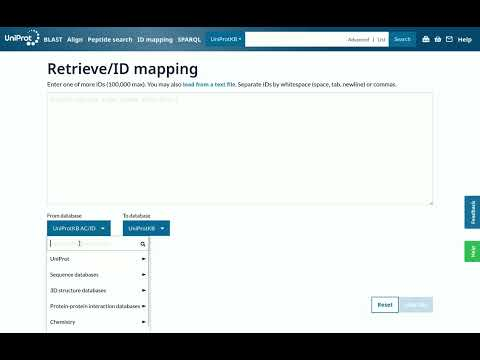

In [12]:
from IPython.display import YouTubeVideo
YouTubeVideo('djzUCJ90Nok')

Agora, arquivo `idmapping.tsv` gerado por esse serviço pode ser lido em um DataFrame.

In [13]:
MAPPING_DIRECTORY_NAME = "idmapping"
MAPPING_FILE_NAME = "idmapping.tsv"
MAPPING_FILE_PATH = os.path.join(DATA_DIRECTORY, MAPPING_DIRECTORY_NAME, MAPPING_FILE_NAME)

mapping_df = pd.read_csv(MAPPING_FILE_PATH, delimiter='\t')
mapping_df

,From,Entry,Protein names,Organism
0,6A94,P0ABE7,Soluble cytochrome b562 (Cytochrome b-562),Escherichia coli
1,6A94,P28223,5-hydroxytryptamine receptor 2A (5-HT-2) (5-HT...,Homo sapiens (Human)
2,5IU8,P0ABE7,Soluble cytochrome b562 (Cytochrome b-562),Escherichia coli
3,5IU8,P29274,Adenosine receptor A2a,Homo sapiens (Human)
4,6RZ6,P0ABE7,Soluble cytochrome b562 (Cytochrome b-562),Escherichia coli
...,...,...,...,...
46072,6RIE,P68314,DNA-directed RNA polymerase 7 kDa subunit (EC ...,Vaccinia virus (strain Ankara) (VACV)
46073,6RIE,Q76ZQ8,DNA-directed RNA polymerase 19 kDa subunit (EC...,Vaccinia virus (strain Ankara) (VACV)
46074,6RIE,Q76ZS0,DNA-directed RNA polymerase 18 kDa subunit (EC...,Vaccinia virus (strain Ankara) (VACV)
46075,3DDN,P9WNX3,D-3-phosphoglycerate dehydrogenase (PGDH) (EC ...,Mycobacterium tuberculosis (strain ATCC 25618 ...


In [14]:
mapping_df = mapping_df[mapping_df["Organism"] == "Homo sapiens (Human)"]
mapping_df = mapping_df.rename(columns={"From": "PDB ID", "Entry": "UniProtKB ID"})
mapping_df

,PDB ID,UniProtKB ID,Protein names,Organism
1,6A94,P28223,5-hydroxytryptamine receptor 2A (5-HT-2) (5-HT...,Homo sapiens (Human)
3,5IU8,P29274,Adenosine receptor A2a,Homo sapiens (Human)
6,3EML,P29274,Adenosine receptor A2a,Homo sapiens (Human)
7,2VN9,Q13557,Calcium/calmodulin-dependent protein kinase ty...,Homo sapiens (Human)
13,3U88,O00255,Menin,Homo sapiens (Human)
...,...,...,...,...
45979,3VS3,P08631,Tyrosine-protein kinase HCK (EC 2.7.10.2) (Hem...,Homo sapiens (Human)
45982,6ME6,P49286,Melatonin receptor type 1B (Mel-1B-R) (Mel1b r...,Homo sapiens (Human)
45989,3ODU,P61073,C-X-C chemokine receptor type 4 (CXC-R4) (CXCR...,Homo sapiens (Human)
45991,1LWW,O15527,N-glycosylase/DNA lyase [Includes: 8-oxoguanin...,Homo sapiens (Human)


In [15]:
mapped_df = tidy_df.merge(mapping_df, on="PDB ID")
mapped_df

,Unnamed: 0,Ligand ranking,Ligand Name,Site Ranking,Ligand Center Coordinate,Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE),Source,PDB ID,Chain,Ligand Residue Number,TM Score,_original_index,UniProtKB ID,Protein names,Organism
0,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,A0A0B4J240,T cell receptor alpha variable 10,Homo sapiens (Human)
1,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,P15813,Antigen-presenting glycoprotein CD1d (R3G1) (C...,Homo sapiens (Human)
2,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,P61769,Beta-2-microglobulin [Cleaved into: Beta-2-mic...,Homo sapiens (Human)
3,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3,P01848,T cell receptor alpha chain constant,Homo sapiens (Human)
4,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3,P01850,T cell receptor beta constant 1,Homo sapiens (Human)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731389,1126495,2,TAM,2,"(9.550, 14.342, -14.364)",6TMO_D_305_0.3325,SEQUENCE,6TMO,D,305,0.3325,1000861,P61769,Beta-2-microglobulin [Cleaved into: Beta-2-mic...,Homo sapiens (Human)
731390,1126495,2,TAM,2,"(9.550, 14.342, -14.364)",6TMO_D_305_0.3325,SEQUENCE,6TMO,D,305,0.3325,1000861,Q16655,Melanoma antigen recognized by T-cells 1 (MART...,Homo sapiens (Human)
731391,1126497,1,CAC,1,"(22.323, 11.302, -25.536)","5OYJ_C_610_0.4540, 1QG3_A_383_0.4128",STRUCTURE,5OYJ,C,610,0.4540,1000863,P35968,Vascular endothelial growth factor receptor 2 ...,Homo sapiens (Human)
731392,1126501,4,TRE,4,"(-17.024, -0.539, 6.014)",5OYJ_C_612_0.4540,STRUCTURE,5OYJ,C,612,0.4540,1000866,P35968,Vascular endothelial growth factor receptor 2 ...,Homo sapiens (Human)


### Adicionando os *embeddings*

In [16]:
import h5py

In [17]:
EMBEDDINGS_DIRECTORY_NAME = "prot5"
EMBEDDINGS_FILE_NAME = "per-protein.h5"
EMBEDDINGS_FILE_PATH = os.path.join(DATA_DIRECTORY, EMBEDDINGS_DIRECTORY_NAME, EMBEDDINGS_FILE_NAME)

h5_file = h5py.File(EMBEDDINGS_FILE_PATH, 'r')

In [18]:
embeddings_dict = {}

for k, v in h5_file.items():
    embeddings_dict[k] = v[:]

embeddings_df = pd.DataFrame(h5_file.keys(), columns=["UniProtKB ID"])
embeddings_df['Embedding'] = embeddings_df["UniProtKB ID"].apply(lambda x: embeddings_dict[x])
embeddings_df


,UniProtKB ID,Embedding
0,A0A024R1R8,"[0.0136, 0.03845, 0.03928, -0.0675, -0.02478, ..."
1,A0A024RBG1,"[0.05814, -0.00346, 0.01235, 0.00528, -0.00479..."
2,A0A024RCN7,"[0.0765, 0.09283, -0.01796, -0.03084, -0.11487..."
3,A0A075B6H5,"[-0.013695, 0.01872, 0.03156, -0.01376, -0.040..."
4,A0A075B6H7,"[-0.006634, 0.1047, 0.04846, -0.02766, -0.0466..."
...,...,...
20582,V9GZ13,"[0.01411, -0.03925, -0.0438, 0.00895, 0.02959,..."
20583,W5XKT8,"[-0.005398, -0.0164, 0.02481, 0.00849, -0.0183..."
20584,W6CW81,"[0.04953, -0.02298, 0.09766, 0.02063, -0.02242..."
20585,X6R8D5,"[0.01906, 0.02252, -0.0001704, 0.01918, -0.101..."


In [19]:
embedded_df = mapped_df.merge(embeddings_df, on="UniProtKB ID")
embedded_df


,Unnamed: 0,Ligand ranking,Ligand Name,Site Ranking,Ligand Center Coordinate,Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE),Source,PDB ID,Chain,Ligand Residue Number,TM Score,_original_index,UniProtKB ID,Protein names,Organism,Embedding
0,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,A0A0B4J240,T cell receptor alpha variable 10,Homo sapiens (Human),"[-0.004986, 0.03047, 0.010735, 0.01293, -0.034..."
1,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,P15813,Antigen-presenting glycoprotein CD1d (R3G1) (C...,Homo sapiens (Human),"[-0.04117, 0.0322, 0.03775, 0.00952, -0.01785,..."
2,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,P61769,Beta-2-microglobulin [Cleaved into: Beta-2-mic...,Homo sapiens (Human),"[-0.01874, 0.04916, 0.00969, -0.02368, 0.00656..."
3,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3,P01848,T cell receptor alpha chain constant,Homo sapiens (Human),"[0.04257, -0.02495, 0.05762, 0.0624, 0.01094, ..."
4,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3,P01850,T cell receptor beta constant 1,Homo sapiens (Human),"[0.01142, 0.05823, 0.02934, 0.01851, 0.000608,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730489,1126495,2,TAM,2,"(9.550, 14.342, -14.364)",6TMO_D_305_0.3325,SEQUENCE,6TMO,D,305,0.3325,1000861,P61769,Beta-2-microglobulin [Cleaved into: Beta-2-mic...,Homo sapiens (Human),"[-0.01874, 0.04916, 0.00969, -0.02368, 0.00656..."
730490,1126495,2,TAM,2,"(9.550, 14.342, -14.364)",6TMO_D_305_0.3325,SEQUENCE,6TMO,D,305,0.3325,1000861,Q16655,Melanoma antigen recognized by T-cells 1 (MART...,Homo sapiens (Human),"[-0.004208, -0.02652, -0.0006356, 0.02728, -0...."
730491,1126497,1,CAC,1,"(22.323, 11.302, -25.536)","5OYJ_C_610_0.4540, 1QG3_A_383_0.4128",STRUCTURE,5OYJ,C,610,0.4540,1000863,P35968,Vascular endothelial growth factor receptor 2 ...,Homo sapiens (Human),"[0.03552, 0.01585, 0.03123, 0.02003, -0.01298,..."
730492,1126501,4,TRE,4,"(-17.024, -0.539, 6.014)",5OYJ_C_612_0.4540,STRUCTURE,5OYJ,C,612,0.4540,1000866,P35968,Vascular endothelial growth factor receptor 2 ...,Homo sapiens (Human),"[0.03552, 0.01585, 0.03123, 0.02003, -0.01298,..."


### Salvando o dataset final

In [20]:
FINAL_FILE_NAME = "final.csv"
FINAL_FILE_PATH = os.path.join(DATA_DIRECTORY, FINAL_FILE_NAME)

final_df = embedded_df

if not os.path.exists(FINAL_FILE_PATH):
    final_df.to_csv(FINAL_FILE_PATH, index=False)

## Análise Exploratória e Seleção de Dados

### Qualidade do alinhamento (TM Score)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Median = 0.7752


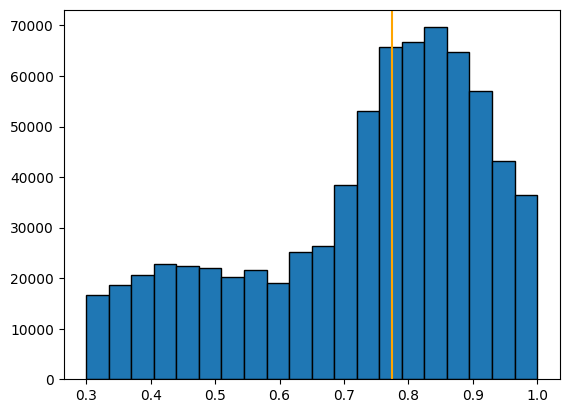

In [22]:
fig, ax = plt.subplots()
y = final_df['TM Score']

ax.hist(y, bins=20, edgecolor='black')

median = np.median(y)
print("Median =", median)
ax.axvline(x=median, color='orange', label='Median')

plt.show()

In [23]:
curated_df = final_df[final_df["TM Score"] >= 0.75]
curated_df

,Unnamed: 0,Ligand ranking,Ligand Name,Site Ranking,Ligand Center Coordinate,Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE),Source,PDB ID,Chain,Ligand Residue Number,TM Score,_original_index,UniProtKB ID,Protein names,Organism,Embedding
0,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,A0A0B4J240,T cell receptor alpha variable 10,Homo sapiens (Human),"[-0.004986, 0.03047, 0.010735, 0.01293, -0.034..."
1,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,P15813,Antigen-presenting glycoprotein CD1d (R3G1) (C...,Homo sapiens (Human),"[-0.04117, 0.0322, 0.03775, 0.00952, -0.01785,..."
2,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,P61769,Beta-2-microglobulin [Cleaved into: Beta-2-mic...,Homo sapiens (Human),"[-0.01874, 0.04916, 0.00969, -0.02368, 0.00656..."
3,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3,P01848,T cell receptor alpha chain constant,Homo sapiens (Human),"[0.04257, -0.02495, 0.05762, 0.0624, 0.01094, ..."
4,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3,P01850,T cell receptor beta constant 1,Homo sapiens (Human),"[0.01142, 0.05823, 0.02934, 0.01851, 0.000608,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730480,1126479,35,URM,1,"(-1.763, 7.813, -8.405)",5C48_A_403_0.8514,STRUCTURE,5C48,A,403,0.8514,1000846,P16442,Histo-blood group ABO system transferase (Fuco...,Homo sapiens (Human),"[0.005173, 0.0378, 0.0666, 0.02321, -0.02026, ..."
730481,1126480,36,1GW,1,"(-2.120, 8.484, -8.756)",3IOI_A_355_0.8438,STRUCTURE,3IOI,A,355,0.8438,1000847,P16442,Histo-blood group ABO system transferase (Fuco...,Homo sapiens (Human),"[0.005173, 0.0378, 0.0666, 0.02321, -0.02026, ..."
730482,1126481,37,48C,1,"(-4.020, 9.199, -7.585)",4Y64_A_402_0.8668,STRUCTURE,4Y64,A,402,0.8668,1000848,P16442,Histo-blood group ABO system transferase (Fuco...,Homo sapiens (Human),"[0.005173, 0.0378, 0.0666, 0.02321, -0.02026, ..."
730483,1126482,38,48E,1,"(-1.297, 10.340, -8.770)",4Y62_A_402_0.8482,STRUCTURE,4Y62,A,402,0.8482,1000849,P16442,Histo-blood group ABO system transferase (Fuco...,Homo sapiens (Human),"[0.005173, 0.0378, 0.0666, 0.02321, -0.02026, ..."


### Número de Proteínas por Ligante

In [24]:
import warnings

Ligand counts:         13445
Ligand counts (> 500): 45


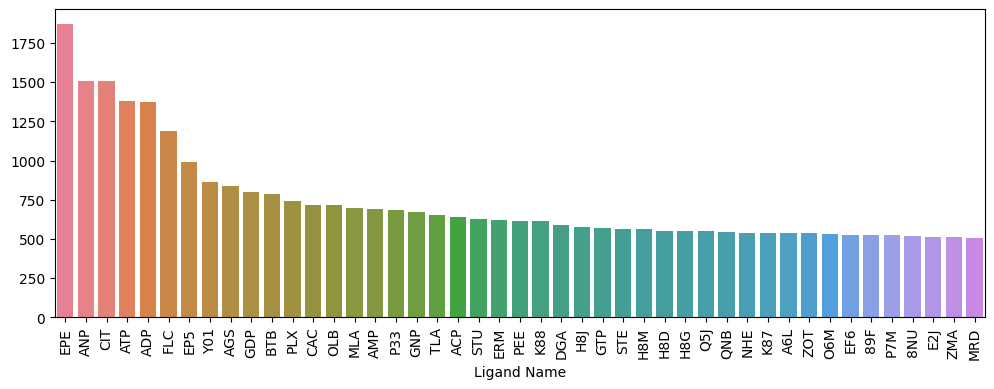

In [25]:
# ignore seaborn warnings
warnings. filterwarnings('ignore')

cutoff = 500
ligand_counts = curated_df['Ligand Name'].value_counts()
ligand_counts_filtered = ligand_counts[ligand_counts > cutoff]

print("Ligand counts:        ", len(ligand_counts))
print(f"Ligand counts (> {cutoff}):", len(ligand_counts_filtered))

fig, ax = plt.subplots(figsize=(12,4))
y = ligand_counts_filtered
num_colors = len(ligand_counts_filtered) + 10
colors = sns.color_palette("husl", num_colors)
sns.barplot(x=y.index, y=y.values, hue=y.index, palette=colors)
plt.xticks(rotation=90)
plt.show()

Ligand counts (no outliers): 38


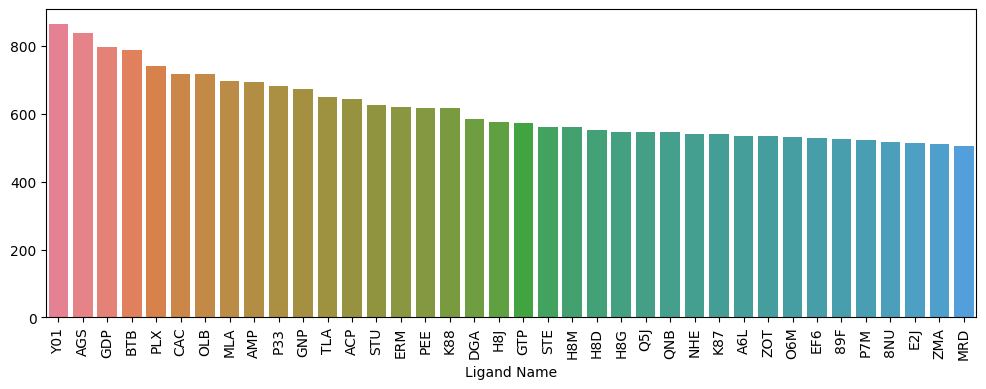

In [26]:
remove_greater_n = 7
ligand_counts_filtered_no_outliers = ligand_counts_filtered.tail(len(ligand_counts_filtered) - remove_greater_n)

print("Ligand counts (no outliers):", len(ligand_counts_filtered) - remove_greater_n)

fig, ax = plt.subplots(figsize=(12,4))
y = ligand_counts_filtered_no_outliers
num_colors = len(ligand_counts_filtered) + 10
colors = sns.color_palette("husl", num_colors)
sns.barplot(x=y.index, y=y.values, hue=y.index, palette=colors)
plt.xticks(rotation=90)
plt.show()

In [27]:
ligand_counts_filtered.to_frame()
subset_df = curated_df.merge(ligand_counts_filtered_no_outliers, on="Ligand Name")
subset_df

,Unnamed: 0,Ligand ranking,Ligand Name,Site Ranking,Ligand Center Coordinate,Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE),Source,PDB ID,Chain,Ligand Residue Number,TM Score,_original_index,UniProtKB ID,Protein names,Organism,Embedding,count
0,60,9,OLB,7,"(24.965, 1.217, -6.225)",5LWY_L_402_0.9185,STRUCTURE,5LWY,L,402,0.9185,60,Q86V24,Adiponectin receptor protein 2 (Progestin and ...,Homo sapiens (Human),"[0.05737, 0.0566, 0.03403, 0.0397, 0.0163, 0.0...",718
1,114,1,OLB,1,"(11.735, -11.289, -19.956)",5LWY_L_402_0.9665,STRUCTURE,5LWY,L,402,0.9665,114,Q86V24,Adiponectin receptor protein 2 (Progestin and ...,Homo sapiens (Human),"[0.05737, 0.0566, 0.03403, 0.0397, 0.0163, 0.0...",718
2,198,6,OLB,6,"(14.561, 8.349, -24.011)",5LWY_L_402_0.9139,STRUCTURE,5LWY,L,402,0.9139,197,Q86V24,Adiponectin receptor protein 2 (Progestin and ...,Homo sapiens (Human),"[0.05737, 0.0566, 0.03403, 0.0397, 0.0163, 0.0...",718
3,332,2,OLB,2,"(11.214, 14.053, -19.075)",5LWY_L_402_0.8471,STRUCTURE,5LWY,L,402,0.8471,329,Q86V24,Adiponectin receptor protein 2 (Progestin and ...,Homo sapiens (Human),"[0.05737, 0.0566, 0.03403, 0.0397, 0.0163, 0.0...",718
4,398,2,OLB,2,"(8.447, 5.214, -23.425)",5LWY_L_402_0.8280,STRUCTURE,5LWY,L,402,0.8280,394,Q86V24,Adiponectin receptor protein 2 (Progestin and ...,Homo sapiens (Human),"[0.05737, 0.0566, 0.03403, 0.0397, 0.0163, 0.0...",718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23341,1126168,56,ACP,1,"(4.069, 8.390, -4.800)",6RU6_A_301_0.7894,STRUCTURE,6RU6,A,301,0.7894,1000601,P48730,Casein kinase I isoform delta (CKI-delta) (CKI...,Homo sapiens (Human),"[0.0818, 0.1201, -0.00881, 0.01496, -0.01082, ...",643
23342,1126168,56,ACP,1,"(4.069, 8.390, -4.800)",6RU6_A_301_0.7894,STRUCTURE,6RU6,A,301,0.7894,1000601,Q9H3D4,Tumor protein 63 (p63) (Chronic ulcerative sto...,Homo sapiens (Human),"[0.04688, 0.04526, 0.0166, 0.05988, 0.00612, 0...",643
23343,1126309,1,CAC,1,"(4.681, 16.727, -4.023)",2J6E_H_1447_0.8928,SEQUENCE,2J6E,H,1447,0.8928,1000716,P01857,Immunoglobulin heavy constant gamma 1 (Ig gamm...,Homo sapiens (Human),"[0.00725, 0.08417, 0.046, 0.01036, -0.01434, -...",719
23344,1126332,1,CAC,1,"(0.229, -13.701, -6.046)",2J6E_H_1447_0.9052,SEQUENCE,2J6E,H,1447,0.9052,1000739,P01857,Immunoglobulin heavy constant gamma 1 (Ig gamm...,Homo sapiens (Human),"[0.00725, 0.08417, 0.046, 0.01036, -0.01434, -...",719


### Entendendo os ligantes

Para melhor compreender os ligantes, podemos acessar suas paǵinas no PDB. O código abaixo gera os *links* para tais páginas.

In [28]:
ligands = subset_df["Ligand Name"].value_counts()

for ligand in ligands.index:
    print(f"{ligand}: https://www.rcsb.org/ligand/{ligand}")

Y01: https://www.rcsb.org/ligand/Y01
AGS: https://www.rcsb.org/ligand/AGS
GDP: https://www.rcsb.org/ligand/GDP
BTB: https://www.rcsb.org/ligand/BTB
PLX: https://www.rcsb.org/ligand/PLX
CAC: https://www.rcsb.org/ligand/CAC
OLB: https://www.rcsb.org/ligand/OLB
MLA: https://www.rcsb.org/ligand/MLA
AMP: https://www.rcsb.org/ligand/AMP
P33: https://www.rcsb.org/ligand/P33
GNP: https://www.rcsb.org/ligand/GNP
TLA: https://www.rcsb.org/ligand/TLA
ACP: https://www.rcsb.org/ligand/ACP
STU: https://www.rcsb.org/ligand/STU
ERM: https://www.rcsb.org/ligand/ERM
PEE: https://www.rcsb.org/ligand/PEE
K88: https://www.rcsb.org/ligand/K88
DGA: https://www.rcsb.org/ligand/DGA
H8J: https://www.rcsb.org/ligand/H8J
GTP: https://www.rcsb.org/ligand/GTP
STE: https://www.rcsb.org/ligand/STE
H8M: https://www.rcsb.org/ligand/H8M
H8D: https://www.rcsb.org/ligand/H8D
Q5J: https://www.rcsb.org/ligand/Q5J
H8G: https://www.rcsb.org/ligand/H8G
QNB: https://www.rcsb.org/ligand/QNB
NHE: https://www.rcsb.org/ligand/NHE
K

Dentre esses ligantes, alguns interessantes são:

| Código | Nome | Aplicação |
|--------|------|-----------|
| [TLA](https://www.rcsb.org/ligand/TLA) | *Tartaric acid* | Tratamento de indigestão, asia, e pedra no rim |
| [ERM](https://www.rcsb.org/ligand/ERM) | *Ergotamine* | Prevenção e interrupção de enxaqueca |
| [H8D](https://www.rcsb.org/ligand/H8D) | *Metilergometrina* | Prevenção e controle de sangramento pós-parto |
| [H8G](https://www.rcsb.org/ligand/H8G) | *Lisuride* | Tratamento da doença de Parkinson |
| [ZOT](https://www.rcsb.org/ligand/ZOT) | *Zotepina* | Tratamento de episódios agudos de esquizofrenia |
| [8NU](https://www.rcsb.org/ligand/8NU) | *Risperidone* | Tratamento de esquizofrenia e transtorno bipolar |
| [O6M](https://www.rcsb.org/ligand/O6M) | E-7820 | Investigado para tratamento de câncer de cólon e câncer retal |
| [EF6](https://www.rcsb.org/ligand/EF6) | *Indisulam* | Investigado para tratamento de câncer de pulmão |
| [P7M](https://www.rcsb.org/ligand/P7M) | *Tasisulam* | Investigado para tratamento de câncer de mama de ovário |
| [E2J](https://www.rcsb.org/ligand/E2J) | *Ritanserin* | Investigado para tratamento de transtornos relacionados à cocaína |





## Classificação

### Codificação posicional

Utilizaremos *positional encoding* para fazer um *embedding* da coluna "Ligand Residue Number".

In [29]:
def position_embeddings(max_binding_position, d=1024, n=10000):
    P = np.zeros((max_binding_position, d))

    for k in range(max_binding_position):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
            
    return P

In [30]:
def generate_positional_encodings(max_binding_site) -> np.ndarray:
    pos_encodings=position_embeddings(max_binding_site)
    return pos_encodings

### Função de treinamento

A função abaixo será usada para treinar múltiplos models, usando diferentes partições do dataset (apenas sequências, apenas estruturas, e ambos).

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle

In [36]:
RESULTS_DIRECTORY_NAME: str = 'results'
MODELS_DIRECTORY_NAME: str = 'models'
REPORTS_DIRECTORY_NAME: str = 'reports'

MODELS_DIRECTORY_PATH: str = os.path.join(RESULTS_DIRECTORY_NAME, MODELS_DIRECTORY_NAME)
REPORTS_DIRECTORY_PATH: str = os.path.join(RESULTS_DIRECTORY_NAME, REPORTS_DIRECTORY_NAME)

In [39]:
def train(df: pd.DataFrame, description: str) -> None:

    # Fazer codificação posicional da coluna "Ligand Residue Number"
    max_binding_site=max(df["Ligand Residue Number"])+1
    pos_encodings = generate_positional_encodings(max_binding_site)

    # Definir input (X) e output (Y) do modelo
    X_embedding = list(df["Embedding"])
    X_number = list(df["Ligand Residue Number"])
    X_number = list(map(lambda x: pos_encodings[x, :], X_number))
    X = [x+s for x,s in zip(X_embedding, X_number)]
    Y = list(df["Ligand Name"])

    # Segmentar o dataset
    x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=120, stratify=Y)

    # Treinar um modelo de regressão logística
    model = LogisticRegression(penalty='l2', max_iter=300)
    model.fit(x_train, y_train)

    # Fazer validação cruzada
    cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", cv_scores.mean())

    # Salvar o modelo
    PICKLE_FILE_NAME = description + ".pkl"
    PICKLE_FILE_PATH = os.path.join(MODELS_DIRECTORY_PATH, PICKLE_FILE_NAME)
    with open(PICKLE_FILE_PATH,'wb') as f:
        pickle.dump(model,f)

    # Gerar um relatório de performance do modelo
    report = classification_report(model.predict(x_test), y_test, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)


    # Salvar o relatório de performance do modelo
    REPORT_FILE_NAME = description + ".csv"
    REPORT_FILE_PATH = os.path.join(REPORTS_DIRECTORY_PATH, REPORT_FILE_NAME)
    report_df.to_csv(REPORT_FILE_PATH, index=True)

### Modelo I: Sequências

In [40]:
seq_df = subset_df[subset_df["Source"] == "SEQUENCE"]
train(df=seq_df, description="sequence")

Cross-validation scores: [0.9047619  0.90750916 0.9134219  0.90426019 0.90563445]
Mean cross-validation score: 0.9071175198293842
              precision    recall  f1-score      support
89F            1.000000  0.993711  0.996845   159.000000
8NU            0.000000  0.000000  0.000000     0.000000
A6L            1.000000  1.000000  1.000000   161.000000
ACP            0.875000  0.958904  0.915033    73.000000
AGS            0.926667  0.945578  0.936027   147.000000
AMP            0.886792  0.969072  0.926108    97.000000
BTB            0.979167  0.959184  0.969072    98.000000
CAC            0.991935  0.968504  0.980080   127.000000
DGA            1.000000  0.994318  0.997151   176.000000
E2J            1.000000  0.962500  0.980892   160.000000
ERM            0.365591  1.000000  0.535433    68.000000
GDP            0.872000  0.825758  0.848249   132.000000
GNP            0.871287  0.792793  0.830189   111.000000
GTP            0.640449  0.876923  0.740260    65.000000
H8D            

### Modelo II: Estruturas

In [41]:
str_df = subset_df[subset_df["Source"] == "STRUCTURE"]
train(df=str_df, description="structure")

Cross-validation scores: [0.92995392 0.9437788  0.90875576 0.93179724 0.93450185]
Mean cross-validation score: 0.9297575118608329
              precision    recall  f1-score      support
ACP            0.893805  1.000000  0.943925   101.000000
AGS            0.930693  0.895238  0.912621   105.000000
AMP            0.883495  0.947917  0.914573    96.000000
BTB            0.992857  0.992857  0.992857   140.000000
CAC            0.978261  0.947368  0.962567    95.000000
DGA            0.000000  0.000000  0.000000     0.000000
EF6            0.981013  0.993590  0.987261   156.000000
GDP            0.912281  0.825397  0.866667   126.000000
GNP            0.861386  0.925532  0.892308    94.000000
GTP            0.722892  0.845070  0.779221    71.000000
K88            1.000000  1.000000  1.000000    82.000000
MLA            0.956204  0.977612  0.966790   134.000000
MRD            0.936842  1.000000  0.967391    89.000000
NHE            0.844444  0.926829  0.883721    41.000000
O6M            

### Modelo III: Sequências e Estruturas

In [42]:
both_df = subset_df
train(df=both_df, description="both")

Cross-validation scores: [0.92811257 0.92597125 0.92564259 0.92900857 0.92962056]
Mean cross-validation score: 0.9276711087014883
              precision    recall  f1-score      support
89F            1.000000  0.975309  0.987500   162.000000
8NU            0.000000  0.000000  0.000000     0.000000
A6L            1.000000  1.000000  1.000000   161.000000
ACP            0.943005  0.978495  0.960422   186.000000
AGS            0.948207  0.933333  0.940711   255.000000
AMP            0.908654  0.887324  0.897862   213.000000
BTB            0.978903  0.950820  0.964657   244.000000
CAC            1.000000  0.981818  0.990826   220.000000
DGA            0.994318  0.988701  0.991501   177.000000
E2J            1.000000  0.980892  0.990354   157.000000
EF6            0.993671  1.000000  0.996825   157.000000
ERM            0.403226  1.000000  0.574713    75.000000
GDP            0.853556  0.829268  0.841237   246.000000
GNP            0.841584  0.880829  0.860759   193.000000
GTP            

## Discussão dos Resultados

Os três modelos tiveram performance excelente, com acurácia média superior a 90%. O resultado mais interessante foi que o modelo I (que foi treinado apenas com dados de sequência) teve performance muito próxima dos modelos II e III (que foram treinados usando dados de estrutura). Isso é uma excelente notícia, pois computar as estruturas das proteínas é uma tarefa computacionalmente custosa, então foi interessante demonstrar que é possível obter um modelo performático sem esses dados de estrutura.

## Referências

> ELNAGGAR, A. et al. ProtTrans: Towards Cracking the Language of Lifes Code Through Self-Supervised Deep Learning and High Performance Computing. **IEEE Transactions on Pattern Analysis and Machine Intelligence**, p. 1–1, 2021.
>
> FISER, A. Template-Based Protein Structure Modeling. **Methods in Molecular Biology**, p. 73–94, 2010. 
>
> HEO, L. et al. GalaxySite: ligand-binding-site prediction by using molecular docking. **Nucleic Acids Research**, v. 42, n. W1, p. W210–W214, 21 abr. 2014.
>
> **PDB101: Learn: Guide to Understanding PDB Data: Small Molecule Ligands**. Disponível em: <https://pdb101.rcsb.org/learn/guide-to-understanding-pdb-data/small-molecule-ligands>. Acesso em: 5 jun. 2024.
>
> QU, X. et al. **A Guide to Template Based Structure Prediction**. Current Protein & Peptide Science, v. 10, n. 3, p. 270–285, 1 jun. 2009. 
>
> SAEED, M. **A Gentle Introduction to Positional Encoding In Transformer Models, Part 1**. Disponível em: <https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/>.
>
>SAGE BIONETWORKS. **CAFA - UniProt Metal Binding Challenge**. Disponível em: <https://www.synapse.org/Synapse:syn50209128/wiki/620259>. Acesso em: 4 jun. 2024.
>
> SARKER, B. et al. **Tutorial VT2: Protein Sequence Analysis using Transformer-based Large Language Model**. Disponível em: <https://github.com/Bishnukuet/ISMB_ECCB_2023_Tutorial-VT2-LLM-For-Protein-Sequence-Analysis>. Acesso em: 4 jun. 2024.
>
> SIM, J.; KWON, S.; SEOK, C. HProteome-BSite: predicted binding sites and ligands in human 3D proteome. **Nucleic acids research**, v. 51, n. D1, p. D403–D408, 16 out. 2022.
>
> **UniProtKB/Swiss-Prot**. Disponível em: <https://web.expasy.org/docs/swiss-prot_guideline.html>.
>
> WANG, R. et al. The PDBbind Database:  Collection of Binding Affinities for Protein−Ligand Complexes with Known Three-Dimensional Structures. **Journal of Medicinal Chemistry**, v. 47, n. 12, p. 2977–2980, jun. 2004. 